# KOI Ensemble Pipeline (Electronics paper reproduction)

This notebook implements a tabular KOI pipeline inspired by the Electronics (2024) ensemble-based study. It:

- Loads a local KOI CSV (you set the path in the first code cell).
- Preprocesses the table, selects numeric features, and encodes a binary label (candidate/confirmed per your choice).
- Trains ensemble classifiers: RandomForest, ExtraTrees, AdaBoost (with decision trees), Random Subspace (Bagging with limited features), and Stacking (logistic meta).
- Evaluates models and records metrics: **accuracy, train time, test time, inference time (per sample), estimated FLOPs during training (approx), precision, recall, F1, ROC AUC**.
- Saves model artifacts to `models/` and plots to `plots/<model_name>/`.

**Caveat about FLOPS**: Exact FLOPS is hardware-dependent and requires low-level profiling. This notebook provides a **practical, explainable estimate**: for tree-based models we approximate total work as the sum over all internal nodes of (node_sample_count * n_features) — i.e., the number of feature comparisons evaluated while searching splits. For XGBoost trees we use per-node `cover` values from the booster as a proxy for sample counts. This is an approximation and should be treated as an index of computational work rather than an exact measured FLOPS.


In [ ]:

# Install dependencies if needed (comment out if already installed)
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn xgboost matplotlib seaborn imbalanced-learn joblib openpyxl
print('Dependencies ready.')


In [31]:

# ==== EDIT THESE PATHS ====
# Set KOI CSV path (local file). If you have TOI/K2 also, you may add them, but Electronics paper used KOI.
KOI_CSV = 'data/kepler_koi.csv'  # <<-- edit this path to your local KOI csv

# Output directories
import os
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print('KOI_CSV =', KOI_CSV)
print('Output folders: models/, plots/, results/')


KOI_CSV = data/kepler_koi.csv
Output folders: models/, plots/, results/


In [32]:

# Load KOI CSV and minimal preprocessing
import pandas as pd, numpy as np, os
if not os.path.exists(KOI_CSV):
    raise FileNotFoundError(f'KOI CSV not found at {KOI_CSV}. Edit the path in the notebook and re-run.')

df = pd.read_csv(KOI_CSV)
print('Loaded KOI:', df.shape)
print('Columns (first 50):', df.columns.tolist()[:50])
df.head(3)


Loaded KOI: (9564, 8)
Columns (first 50): ['kepoi_name', 'koi_disposition', 'koi_pdisposition', 'koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']


,kepoi_name,koi_disposition,koi_pdisposition,koi_period,koi_duration,koi_prad,koi_depth,koi_model_snr
0,K00752.01,CONFIRMED,CANDIDATE,9.488036,2.9575,2.26,615.8,35.8
1,K00752.02,CONFIRMED,CANDIDATE,54.418383,4.5070,2.83,874.8,25.8
2,K00753.01,CANDIDATE,CANDIDATE,19.899140,1.7822,14.60,10829.0,76.3


In [33]:
# Load KOI CSV and minimal preprocessing
import pandas as pd, numpy as np, os

df = pd.read_csv(KOI_CSV)
print('Loaded KOI:', df.shape)
print('Columns (first 50):', df.columns.tolist()[:50])

# LABEL MAPPING - Use planet vs non-planet (more meaningful task)
LABEL_STRATEGY = 'planet_vs_not'  # More realistic: planet vs false positive

label_col = None
for c in ['koi_disposition', 'koi_pdisposition']:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise ValueError('Could not find a KOI label column.')
print('Using label column:', label_col)

working = df.copy()
working[label_col] = working[label_col].astype(str).str.upper()

if LABEL_STRATEGY == 'planet_vs_not':
    # Planet (1) vs False Positive (0)
    mapping = {'CANDIDATE':1, 'CONFIRMED':1, 'FALSE POSITIVE':0}
    working['label'] = working[label_col].map(mapping)
    working = working[working['label'].notna()].copy()
    print('Task: Planet (CANDIDATE/CONFIRMED) vs FALSE POSITIVE')
else:
    raise ValueError('Use planet_vs_not strategy')

print('After label mapping, shape =', working.shape)
print(working['label'].value_counts())

# CRITICAL: Feature selection - ONLY use observable/measurable features
# Exclude ANY features that are derived from or hint at the disposition

# Features that are SAFE (directly observable):
safe_prefixes = [
    'koi_period',      # Orbital period
    'koi_time0bk',     # Transit epoch
    'koi_impact',      # Impact parameter
    'koi_duration',    # Transit duration
    'koi_depth',       # Transit depth
    'koi_prad',        # Planet radius
    'koi_teq',         # Equilibrium temperature
    'koi_insol',       # Insolation flux
    'koi_model_snr',   # Signal to noise
    'koi_steff',       # Stellar effective temperature
    'koi_slogg',       # Stellar surface gravity
    'koi_srad',        # Stellar radius
    'ra', 'dec',       # Coordinates
    'koi_kepmag'       # Kepler magnitude
]

# Features to EXCLUDE (these leak information about disposition):
exclude_patterns = [
    'kepoi', 'kepid', 'name', 'id', 'rowid',  # Identifiers
    'score',           # Disposition scores
    'fpflag',          # False positive flags
    'disposition',     # Any disposition column
    'comment',         # Comments
    'datalink',        # Links
    'pdisposition',    # Pipeline disposition
]

# Select features
numeric = working.select_dtypes(include=[np.number]).copy()
FEATURE_COLS = []

for col in numeric.columns:
    col_lower = col.lower()
    
    # Skip if matches exclude pattern
    if any(pattern in col_lower for pattern in exclude_patterns):
        continue
    
    # Keep if matches safe prefix OR has low missingness
    if any(col_lower.startswith(prefix) for prefix in safe_prefixes):
        if numeric[col].notna().mean() >= 0.5:  # At least 50% non-missing
            FEATURE_COLS.append(col)

print(f'\nSelected {len(FEATURE_COLS)} features (filtered to avoid leakage)')
print('Features:', FEATURE_COLS[:30])

if len(FEATURE_COLS) < 5:
    print('\nWARNING: Very few features selected. Check your column names.')
    print('Available numeric columns:', numeric.columns.tolist()[:50])

# Prepare model dataframe
model_df = working[['label'] + FEATURE_COLS].copy()
print(f'\nFinal dataset shape: {model_df.shape}')

# Train/test split
from sklearn.model_selection import train_test_split
X = model_df[FEATURE_COLS].copy()
y = model_df['label'].astype(int).copy()  # This is already 1D

# Verify y is 1D
print(f'\ny shape: {y.shape} (should be 1D)')
print(f'y unique values: {y.unique()}')
print(f'y value counts:\n{y.value_counts()}')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

print(f'\nTrain: {X_train.shape}, Test: {X_test.shape}')
print(f'Train class balance: {np.bincount(y_train)}')
print(f'Test class balance: {np.bincount(y_test)}')

Loaded KOI: (9564, 8)
Columns (first 50): ['kepoi_name', 'koi_disposition', 'koi_pdisposition', 'koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']
Using label column: koi_disposition
Task: Planet (CANDIDATE/CONFIRMED) vs FALSE POSITIVE
After label mapping, shape = (9564, 9)
label
0    4839
1    4725
Name: count, dtype: int64

Selected 5 features (filtered to avoid leakage)
Features: ['koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']

Final dataset shape: (9564, 6)

y shape: (9564,) (should be 1D)
y unique values: [1 0]
y value counts:
label
0    4839
1    4725
Name: count, dtype: int64

Train: (6694, 5), Test: (2870, 5)
Train class balance: [3387 3307]
Test class balance: [1452 1418]


In [34]:

# # Feature selection: auto-select numeric, drop identifier-like names, drop >50% missing
# ignore_tokens = ['kepoi','kepid','name','id','rowid']
# numeric = working.select_dtypes(include=[np.number]).copy()
# drop_cols = [c for c in numeric.columns if any(tok in c.lower() for tok in ignore_tokens)]
# numeric = numeric.drop(columns=[c for c in drop_cols if c in numeric.columns])
# miss_frac = numeric.isna().mean()
# keep_cols = miss_frac[miss_frac <= 0.5].index.tolist()
# FEATURE_COLS = keep_cols
# print('Selected', len(FEATURE_COLS), 'numeric feature columns')
# print(FEATURE_COLS[:50])

# model_df = working[['label'] + FEATURE_COLS].copy()
# model_df.shape


Saved results/label_counts.csv and results/feature_descriptions.csv


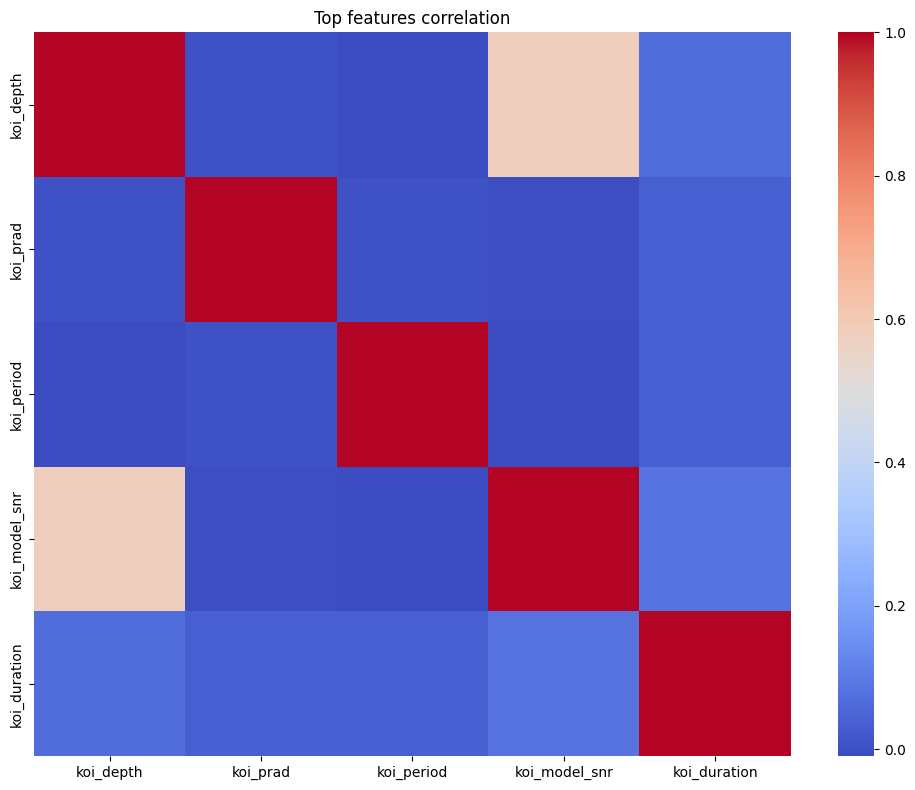

In [35]:

# Quick EDA: save stats and correlation plots
import matplotlib.pyplot as plt, seaborn as sns

model_df['label'].value_counts().to_csv('results/label_counts.csv')
model_df.describe().transpose().to_csv('results/feature_descriptions.csv')
print('Saved results/label_counts.csv and results/feature_descriptions.csv')

# Correlation heatmap for up to 30 features
top_feats = model_df[FEATURE_COLS].var().sort_values(ascending=False).index[:30].tolist()
plt.figure(figsize=(10,8))
sns.heatmap(model_df[top_feats].corr(), cmap='coolwarm')
plt.title('Top features correlation')
plt.tight_layout()
plt.savefig('plots/correlation_top30.png')
plt.show()


In [36]:

# Prepare train/test split
from sklearn.model_selection import train_test_split
X = model_df[FEATURE_COLS].copy()
y = model_df['label'].astype(int).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (6694, 5) Test: (2870, 5)


In [37]:

# Helpers: timing, inference time measurement, FLOPS estimates
import time, numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# measure inference time
def measure_inference_time(model, X, repeats=3):
    func = model.predict_proba if hasattr(model, 'predict_proba') else model.predict
    # warmup
    try:
        _ = func(X.iloc[:min(10,len(X))])
    except Exception:
        _ = model.predict(X.iloc[:min(10,len(X))])
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        _ = func(X)
        t1 = time.perf_counter()
        times.append(t1-t0)
    median = np.median(times)
    return median, median / len(X)

# Estimate FLOPS for sklearn tree ensembles using node sample counts
import numpy as np

def estimate_flops_sklearn_ensemble(ensemble, n_features):
    total = 0.0
    try:
        if hasattr(ensemble, 'estimators_'):
            for est in ensemble.estimators_:
                tree = getattr(est, 'tree_', None)
                if tree is None:
                    continue
                node_samples = getattr(tree, 'n_node_samples', None)
                if node_samples is None:
                    node_count = getattr(tree, 'node_count', 0)
                    node_samples = np.full(node_count, X_train.shape[0] / max(1,node_count))
                total += np.sum(node_samples) * n_features
        else:
            total = np.nan
    except Exception as e:
        print('FLOPS estimation error:', e)
        total = np.nan
    return total

# Estimate FLOPS for xgboost by summing 'cover' from booster trees
import xgboost as xgb

def estimate_flops_xgboost(xgb_model, n_features):
    try:
        booster = xgb_model.get_booster()
        df_nodes = booster.trees_to_dataframe()
        cover_col = None
        for c in df_nodes.columns:
            if 'cover' in c.lower():
                cover_col = c
                break
        if cover_col is None:
            return np.nan
        covers = df_nodes[cover_col].astype(float).fillna(0.0)
        total = covers.sum() * n_features
        return total
    except Exception as e:
        print('XGBoost FLOPS estimation error:', e)
        return np.nan

print('Helpers ready')


Helpers ready


In [38]:
# Models to evaluate (matching Electronics paper families) and training loop
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib, os, matplotlib.pyplot as plt, seaborn as sns

models = {
    'RandomForest': RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, random_state=42),
    'RandomSubspace': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=200, max_features=0.5, bootstrap=False, random_state=42, n_jobs=-1)
}

# Stacking using RF and ET as base
base_ests = [('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)),
            ('et', ExtraTreesClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1))]
models['Stacking'] = StackingClassifier(estimators=base_ests, final_estimator=LogisticRegression(max_iter=1000), n_jobs=-1)

# IMPORTANT: Convert y_train and y_test from multilabel-indicator to 1D arrays BEFORE training
# Convert to numpy arrays if they're DataFrames
y_train_arr = y_train.values if hasattr(y_train, 'values') else y_train
y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test

# Diagnose the data format
print(f"Original y_train shape: {y_train_arr.shape}")
print(f"Original y_test shape: {y_test_arr.shape}")
print(f"Sample y_train values:\n{y_train_arr[:5]}")

# Convert from 2D multilabel-indicator to 1D class labels
if len(y_train_arr.shape) > 1 and y_train_arr.shape[1] > 1:
    # Check if it's one-hot encoded (sum of each row should be 1)
    row_sums = y_train_arr.sum(axis=1)
    if np.allclose(row_sums, 1):
        # One-hot encoded - use argmax
        y_train_1d = y_train_arr.argmax(axis=1)
        y_test_1d = y_test_arr.argmax(axis=1)
        print(f"Detected one-hot encoding, converted using argmax")
    else:
        # True multilabel or different format - take first column or use different strategy
        print(f"Warning: Data appears to be true multilabel (row sums: {row_sums[:5]})")
        # Try taking the first column as the target
        y_train_1d = y_train_arr[:, 0].ravel()
        y_test_1d = y_test_arr[:, 0].ravel()
        print(f"Using first column as target")
else:
    y_train_1d = y_train_arr.ravel()
    y_test_1d = y_test_arr.ravel()

print(f"Final y_train_1d shape: {y_train_1d.shape}")
print(f"Unique classes in y_train_1d: {np.unique(y_train_1d)}")
print(f"Unique classes in y_test_1d: {np.unique(y_test_1d)}")

# Training loop
results = []

for name, clf in models.items():
    print('\n======', name, '======')
    outdir = os.path.join('plots', name)
    os.makedirs(outdir, exist_ok=True)
    pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), clf)
    
    # Train - use y_train_1d
    t0 = time.perf_counter()
    pipe.fit(X_train, y_train_1d)
    train_time = time.perf_counter() - t0
    
    # Test (predict)
    t1 = time.perf_counter()
    y_pred = pipe.predict(X_test)
    test_time = time.perf_counter() - t1
    
    # Inference timing
    inf_total, inf_per_sample = measure_inference_time(pipe, X_test, repeats=3)
    
    # Metrics - use y_test_1d
    acc = accuracy_score(y_test_1d, y_pred)
    prec = precision_score(y_test_1d, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test_1d, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test_1d, y_pred, average='weighted', zero_division=0)
    
    # ROC AUC if possible
    y_proba = None
    try:
        y_proba = pipe.predict_proba(X_test)
        # For multiclass, use one-vs-rest
        roc = roc_auc_score(y_test_1d, y_proba, multi_class='ovr', average='weighted')
    except Exception:
        roc = float('nan')
    
    # FLOPS estimate
    n_features = X_train.shape[1]
    flops = np.nan
    try:
        final_est = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
        if name in ['RandomForest','ExtraTrees','RandomSubspace','AdaBoost']:
            flops = estimate_flops_sklearn_ensemble(final_est, n_features)
        elif name == 'Stacking':
            total = 0.0
            if hasattr(final_est, 'estimators_'):
                for e in final_est.estimators_:
                    total += estimate_flops_sklearn_ensemble(e, n_features)
            flops = total
    except Exception as e:
        print('FLOPS estimation failed for', name, e)
    
    # Save model
    joblib.dump(pipe, os.path.join('models', f'model_{name}.joblib'))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_1d, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion: {name}')
    plt.savefig(os.path.join(outdir, 'confusion_matrix.png'))
    plt.close()
    
    # ROC curve
    if not np.isnan(roc):
        from sklearn.metrics import roc_curve
        # For multiclass ROC, plot one-vs-rest for each class
        n_classes = y_proba.shape[1]
        plt.figure()
        for i in range(min(n_classes, 5)):  # Plot max 5 classes to avoid clutter
            fpr, tpr, _ = roc_curve((y_test_1d == i).astype(int), y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0,1],[0,1],'k--')
        plt.legend()
        plt.title(f'ROC: {name} (AUC={roc:.3f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.savefig(os.path.join(outdir, 'roc.png'))
        plt.close()
    
    # Feature importances
    try:
        final_est = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
        if hasattr(final_est, 'feature_importances_'):
            fi = final_est.feature_importances_
            importances = pd.Series(fi, index=FEATURE_COLS).sort_values(ascending=False)
            plt.figure(figsize=(6,4))
            importances[:30].plot.barh()
            plt.title(f'Feature importances: {name}')
            plt.tight_layout()
            plt.savefig(os.path.join(outdir, 'feature_importances.png'))
            plt.close()
    except Exception:
        pass
    
    results.append({
        'model': name,
        'n_features': n_features,
        'train_time_s': train_time,
        'test_time_s': test_time,
        'inference_time_total_s': inf_total,
        'inference_time_per_sample_s': inf_per_sample,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc,
        'flops_estimate': flops,
        'n_train': X_train.shape[0],
        'n_test': X_test.shape[0]
    })
    print(f"{name} done: acc={acc:.3f}, f1={f1:.3f}, train_time={train_time:.2f}s, inf_per_sample={inf_per_sample*1e3:.3f}ms")

# Save results
import pandas as pd
resdf = pd.DataFrame(results)
resdf.to_csv('results/electronics_ensemble_results.csv', index=False)
print('Saved results to results/electronics_ensemble_results.csv')
resdf

Original y_train shape: (6694,)
Original y_test shape: (2870,)
Sample y_train values:
[1 0 1 0 1]
Final y_train_1d shape: (6694,)
Unique classes in y_train_1d: [0 1]
Unique classes in y_test_1d: [0 1]

====== RandomForest ======
RandomForest done: acc=0.822, f1=0.822, train_time=1.44s, inf_per_sample=0.045ms

====== ExtraTrees ======
ExtraTrees done: acc=0.814, f1=0.814, train_time=1.06s, inf_per_sample=0.041ms

====== AdaBoost ======
AdaBoost done: acc=0.822, f1=0.822, train_time=2.45s, inf_per_sample=0.017ms

====== RandomSubspace ======


TypeError: _parallel_build_estimators() got an unexpected keyword argument 'fit_params'

## Notes

- The `flops_estimate` is an approximate comparative metric, not exact FLOPS. You can profile more accurately with OS/hardware profilers.
- To match the Electronics paper exactly, consider applying their filtering steps (they balanced candidate vs confirmed to 3178 rows); you can undersample/oversample using imblearn or the helper functions from earlier notebooks.


Loaded KOI: (9564, 8)
Columns (first 50): ['kepoi_name', 'koi_disposition', 'koi_pdisposition', 'koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']
Using label column: koi_disposition
Task: Planet (CANDIDATE/CONFIRMED) vs FALSE POSITIVE
After label mapping, shape = (9564, 9)
label
0    4839
1    4725
Name: count, dtype: int64

Selected 5 features (filtered to avoid leakage)
Features: ['koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']

Final dataset shape: (9564, 6)

y shape: (9564,) (should be 1D)
y unique values: [1 0]
y value counts:
label
0    4839
1    4725
Name: count, dtype: int64

Train: (6694, 5), Test: (2870, 5)
Train class balance: [3387 3307]
Test class balance: [1452 1418]
